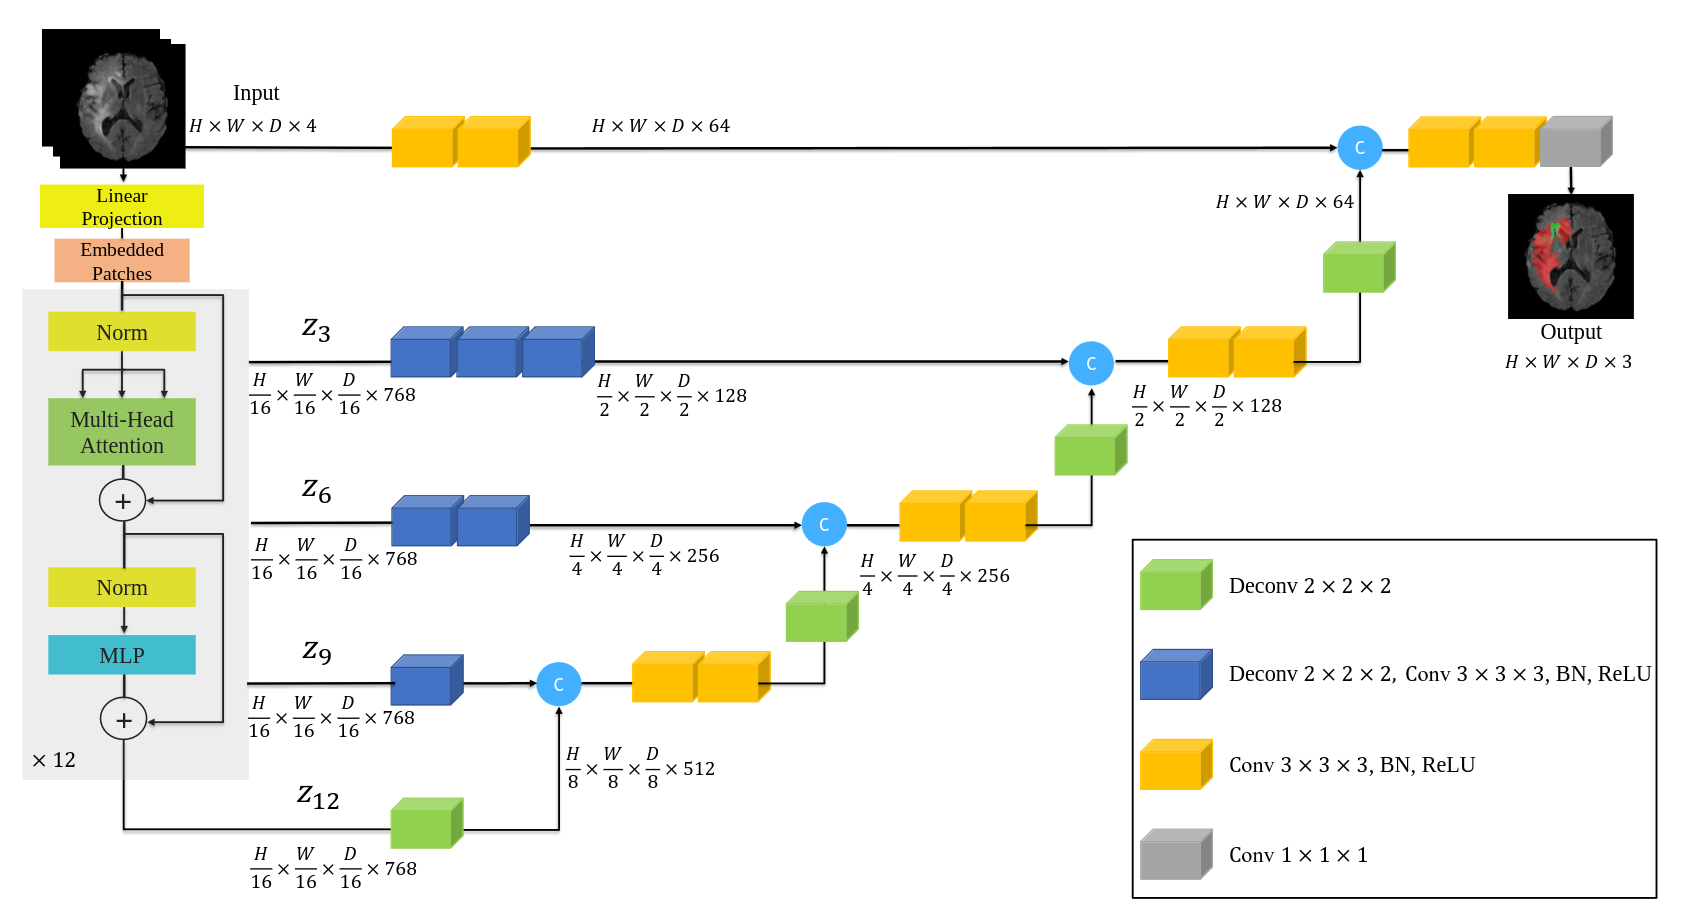

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dim = self.config['dim']
        self.num_heads = self.config['num_heads']
        assert self.dim % self.num_heads == 0, 'dim should be div by num_heads'
        self.head_dim = self.dim // self.num_heads
        
        self.drop = self.config['drop']
        self.qkv = nn.Linear(self.dim, self.dim*3, bias=self.config['bias'])
        
        self.proj = nn.Linear(self.dim, self.dim, bias=self.config['bias'])
        self.attn_drop = nn.Dropout(self.drop)
        self.proj_drop = nn.Dropout(self.drop)
        
    def forward(self, x):
        
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        x = F.scaled_dot_product_attention(
            q, k, v,
            dropout_p=self.drop,
        )
        
        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [3]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.dim = self.config['dim']
        
        self.attn_block = Attention(self.config)
        self.ln1 = nn.LayerNorm(self.dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(self.dim, self.dim*4),
            nn.GELU(),
            nn.Dropout(self.config['drop']),
            nn.Linear(self.dim*4, self.dim),
        )
        self.ln2 = nn.LayerNorm(self.config['dim'])
        
    def forward(self, x):
        
        x += self.attn_block(self.ln1(x))
        x += self.mlp(self.ln2(x))
        
        return x

In [4]:
class YellowBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        self.downsample = self.in_ch != self.out_ch
        
        self.conv_block1 = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, self.kernel_size, self.stride, self.padding),
            nn.InstanceNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, self.kernel_size, self.stride, self.padding),
            nn.InstanceNorm3d(out_ch)
        )
        
        if self.downsample:
            self.conv_block2 = nn.Sequential(
                nn.Conv3d(in_ch, out_ch, 1, 1, 0),
                nn.InstanceNorm3d(out_ch)
            )
            
        self.act2 = nn.ReLU(inplace=True)
            
    def forward(self, x):
        x1 = self.conv_block1(x)
        if self.downsample:
            x = self.conv_block2(x)
        x1 += x
        return self.act2(x)

In [5]:
class BlueBlock(nn.Module):
    def __init__(self, in_ch, out_ch, num_blocks):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.num_blocks = num_blocks
        
        self.transpose_block = nn.ConvTranspose3d(self.in_ch, self.out_ch, 2, 2, 0, bias=False)
        
        self.blue_blocks = nn.ModuleList()
        
        for _ in range(self.num_blocks-1):
            self.blue_blocks.append(
                nn.Sequential(
                    nn.ConvTranspose3d(self.out_ch, self.out_ch, 2, 2, 0, bias=False),
                    nn.Conv3d(self.out_ch, self.out_ch, 3, 1, 1),
                    nn.InstanceNorm3d(self.out_ch),
                    nn.ReLU(inplace=True),
                    nn.Conv3d(self.out_ch, self.out_ch, 3, 1, 1),
                    nn.InstanceNorm3d(self.out_ch)
                )
            )
            
    def forward(self, x):
        x = self.transpose_block(x)
        for block in self.blue_blocks:
            x = block(x)

        return x

In [6]:
class GreenBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=2, stride=2, padding=0):
        super().__init__()
        self.deconv = nn.ConvTranspose3d(in_ch, out_ch, kernel_size, stride, padding)
    
    def forward(self, x):
        return self.deconv(x)

In [7]:
class PatchReshaper(nn.Module):
    def __init__(self, patch_dim):
        super().__init__()
        self.patch_dim = patch_dim
        
    def forward(self, x):
        B, N, C = x.shape
        x = x.transpose(-1,-2)
        x = x.reshape(B,C,*self.patch_dim)
        return x

In [8]:
class UNetR(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.in_ch = self.config['in_ch']
        self.base_ch = self.config['base_ch']
        self.dim = self.config['dim']
        self.img_size = self.config['img_size']
        self.patch_size = self.config['patch_size']
        
        self.patch_dim = [x//self.patch_size for x in self.img_size]
        
        self.num_patches = (self.img_size[0]*self.img_size[1]*self.img_size[2]) // (self.config['patch_size']**3)
        
        self.patch_embedding = nn.Conv3d(
            self.in_ch,
            self.dim,
            self.patch_size,
            self.patch_size,
            bias=False
        )
        
        self.pos_embed = nn.Parameter(torch.randn(1,self.num_patches,self.dim)*0.02,requires_grad=True)
        
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(self.config) for _ in range(self.config['num_layers'])
        ])
        
        self.reshaper = PatchReshaper(self.patch_dim)
        
        # initial yellow block
        self.z0_yellow = YellowBlock(self.in_ch, self.base_ch) 
        
        # 3,6,9 blue blocks
        self.z3_blue = BlueBlock(self.dim,self.base_ch*2,3)
        self.z6_blue = BlueBlock(self.dim,self.base_ch*4,2)
        self.z9_blue = BlueBlock(self.dim,self.base_ch*8,1)
        
        # 3, 6, 9, 12 green blocks
        self.z3_green = GreenBlock(self.base_ch*2,self.base_ch)
        self.z6_green = GreenBlock(self.base_ch*4,self.base_ch*2)
        self.z9_green = GreenBlock(self.base_ch*8,self.base_ch*4)
        self.z12_green = GreenBlock(self.dim,self.base_ch*8)
        
        # 3,6,9 yellow blocks
        self.z3_yellow = YellowBlock(self.base_ch * 2 * 2, self.base_ch * 2)
        self.z6_yellow = YellowBlock(self.base_ch * 4 * 2, self.base_ch * 4)
        self.z9_yellow = YellowBlock(self.base_ch * 8 * 2, self.base_ch * 8)
        
        self.output_block = nn.Sequential(
            YellowBlock(self.base_ch * 2, self.base_ch),
            nn.Conv3d(self.base_ch, self.config['num_classes'], 1, 1)
        )
        
    def forward(self, x):
        
        enc_out = x
        B = x.shape[0]
        enc_out = self.patch_embedding(enc_out)
        print(enc_out.shape)
        enc_out = enc_out.reshape(B,self.dim,self.num_patches).transpose(-1,-2)
        enc_out += self.pos_embed
        
        self.skips = []
        for stage_num, block in enumerate(self.transformer_blocks,start=1):
            enc_out = block(enc_out)
            if stage_num in self.config['stages']:
                self.skips.append(self.reshaper(enc_out))
                
        z3,z6,z9,z12 = self.skips
                
        # initial yellow block skip    
        z0 = self.z0_yellow(x)
        
        # blue blocks: 3, 6, 9
        z3 = self.z3_blue(z3)
        z6 = self.z6_blue(z6)
        z9 = self.z9_blue(z9)
        
        # green: 12
        z12 = self.z12_green(z12)
        
        z_12_9 = torch.cat([z12,z9],dim=1)
        z_12_9 = self.z9_yellow(z_12_9)
        
        z_12_9 = self.z9_green(z_12_9)
        z_12_9_6 = torch.cat([z_12_9,z6],dim=1)
        z_12_9_6 = self.z6_yellow(z_12_9_6)
        
        z_12_9_6 = self.z6_green(z_12_9_6)
        z_12_9_6_3 = torch.cat([z_12_9_6, z3],dim=1)
        z_12_9_6_3 = self.z3_yellow(z_12_9_6_3)
        
        z_12_9_6_3 = self.z3_green(z_12_9_6_3)
        
        out = torch.cat([z_12_9_6_3, z0],dim=1)
        out = self.output_block(out)
    
        return x

In [9]:
config = {
    'dim': 512,
    'num_heads': 8,
    'drop': 0.,
    'in_ch': 1,
    'num_classes': 3,
    'img_size': (128,128,128),
    'patch_size': 16,
    'num_layers': 12,
    'stages': [3,6,9,12],
    'bias': False,
    'base_ch': 16
}

In [10]:
model = UNetR(config)

In [11]:
model.patch_dim

[8, 8, 8]

In [12]:
x = torch.rand(2,1,128,128,128)

In [13]:
model.num_patches

512

In [14]:
model(x).shape

torch.Size([2, 512, 8, 8, 8])


torch.Size([2, 1, 128, 128, 128])

In [15]:
[o.shape for o in model.skips]

[torch.Size([2, 512, 8, 8, 8]),
 torch.Size([2, 512, 8, 8, 8]),
 torch.Size([2, 512, 8, 8, 8]),
 torch.Size([2, 512, 8, 8, 8])]

In [16]:
params = lambda m:sum([p.numel() for p in m.parameters() if p.requires_grad])

In [17]:
params(model)

43886819

In [18]:
model

UNetR(
  (patch_embedding): Conv3d(1, 512, kernel_size=(16, 16, 16), stride=(16, 16, 16), bias=False)
  (transformer_blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (attn_block): Attention(
        (qkv): Linear(in_features=512, out_features=1536, bias=False)
        (proj): Linear(in_features=512, out_features=512, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
  (reshaper): PatchReshaper()
  (z0_yellow): YellowBlock(
    (conv_block1): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1),